### Webcam Object Detection using Tensorflow 2
##### Bahy Helmi Hartoyo Putra - bahyhelmi97@gmail.com
- Based on the [Webcam Object Detection - TF Example]('https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html#sphx-glr-auto-examples-object-detection-camera-py'), with a slight modification.
- Using Tensorflow 2 Object Detection API to classify the object on the input video.
- Using pre-recorded webcam video as an input and extract the result video with bounding boxes attached. 

#### Import Libraries

In [7]:
%matplotlib inline

import cv2
import os
import tarfile
import urllib.request

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from glob import glob
from tqdm import tqdm
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

#### Create Directory

In [8]:
# Create data/models directory
DATA_DIR = os.path.join(os.getcwd(), 'data')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
for dir in [DATA_DIR, MODELS_DIR]:
    if not os.path.exists(dir):
        os.mkdir(dir)

#### Download & Extract Model

- The particular detection algorithm that are being used in this session is the **SSD ResNet101 V1 FPN 640x640**.
- These processes of downloading & extracting can always be done manually.

In [9]:
# Download and extract model
MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME


PATH_TO_MODEL_TAR = os.path.join(MODELS_DIR, MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))

if not os.path.exists(PATH_TO_CKPT):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(MODEL_DOWNLOAD_LINK, PATH_TO_MODEL_TAR)
    tar_file = tarfile.open(PATH_TO_MODEL_TAR)
    tar_file.extractall(MODELS_DIR)
    tar_file.close()
    
    os.remove(PATH_TO_MODEL_TAR)
    print('Done')

In [10]:
# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))

if not os.path.exists(PATH_TO_LABELS):
    print('Downloading label file... ', end='')
    urllib.request.urlretrieve(LABELS_DOWNLOAD_BASE + LABEL_FILENAME, PATH_TO_LABELS)
    print('Done')

#### Load the Model

In [12]:
# Enable GPU dynamic memory allocation
# Currently this laptop does not have any GPU, so it won't affect anything
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if len(gpus) == 0:
    print("No GPU(s) available.")

No GPU(s) available.


In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [14]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()
print("Checkpoint restored.")

Checkpoint restored.


In [15]:
@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [18]:
# Check out the first 5 labels
dict(list(category_index.items())[0:5])

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'}}

#### Load the Webcam

In [19]:
# cap = cv2.VideoCapture(0) # Disabled since currently native webcam does not supported on WSL
cap = cv2.VideoCapture('data/videos/webcam.mp4') # Using pre-recorded webcam video
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

In [20]:
# Number of frames and FPS on my input video
n_frames, fps

(508, 15)

#### Predict Frames

In [21]:
print("Processing videos..", end="")
for i in tqdm(range(n_frames-1)):
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Converting image frame into tensor
    input_tensor = tf.convert_to_tensor(image_np_expanded, dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    # Putting bounding box and label on frame
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    image_np_with_detections = cv2.resize(image_np_with_detections, (800, 600))
    cv2.imwrite("data/frames/%s.jpg" % i, image_np_with_detections)

  0%|          | 0/507 [00:00<?, ?it/s]

Processing videos..

100%|██████████| 507/507 [11:54<00:00,  1.41s/it]


In [22]:
# Release the video
cap.release()

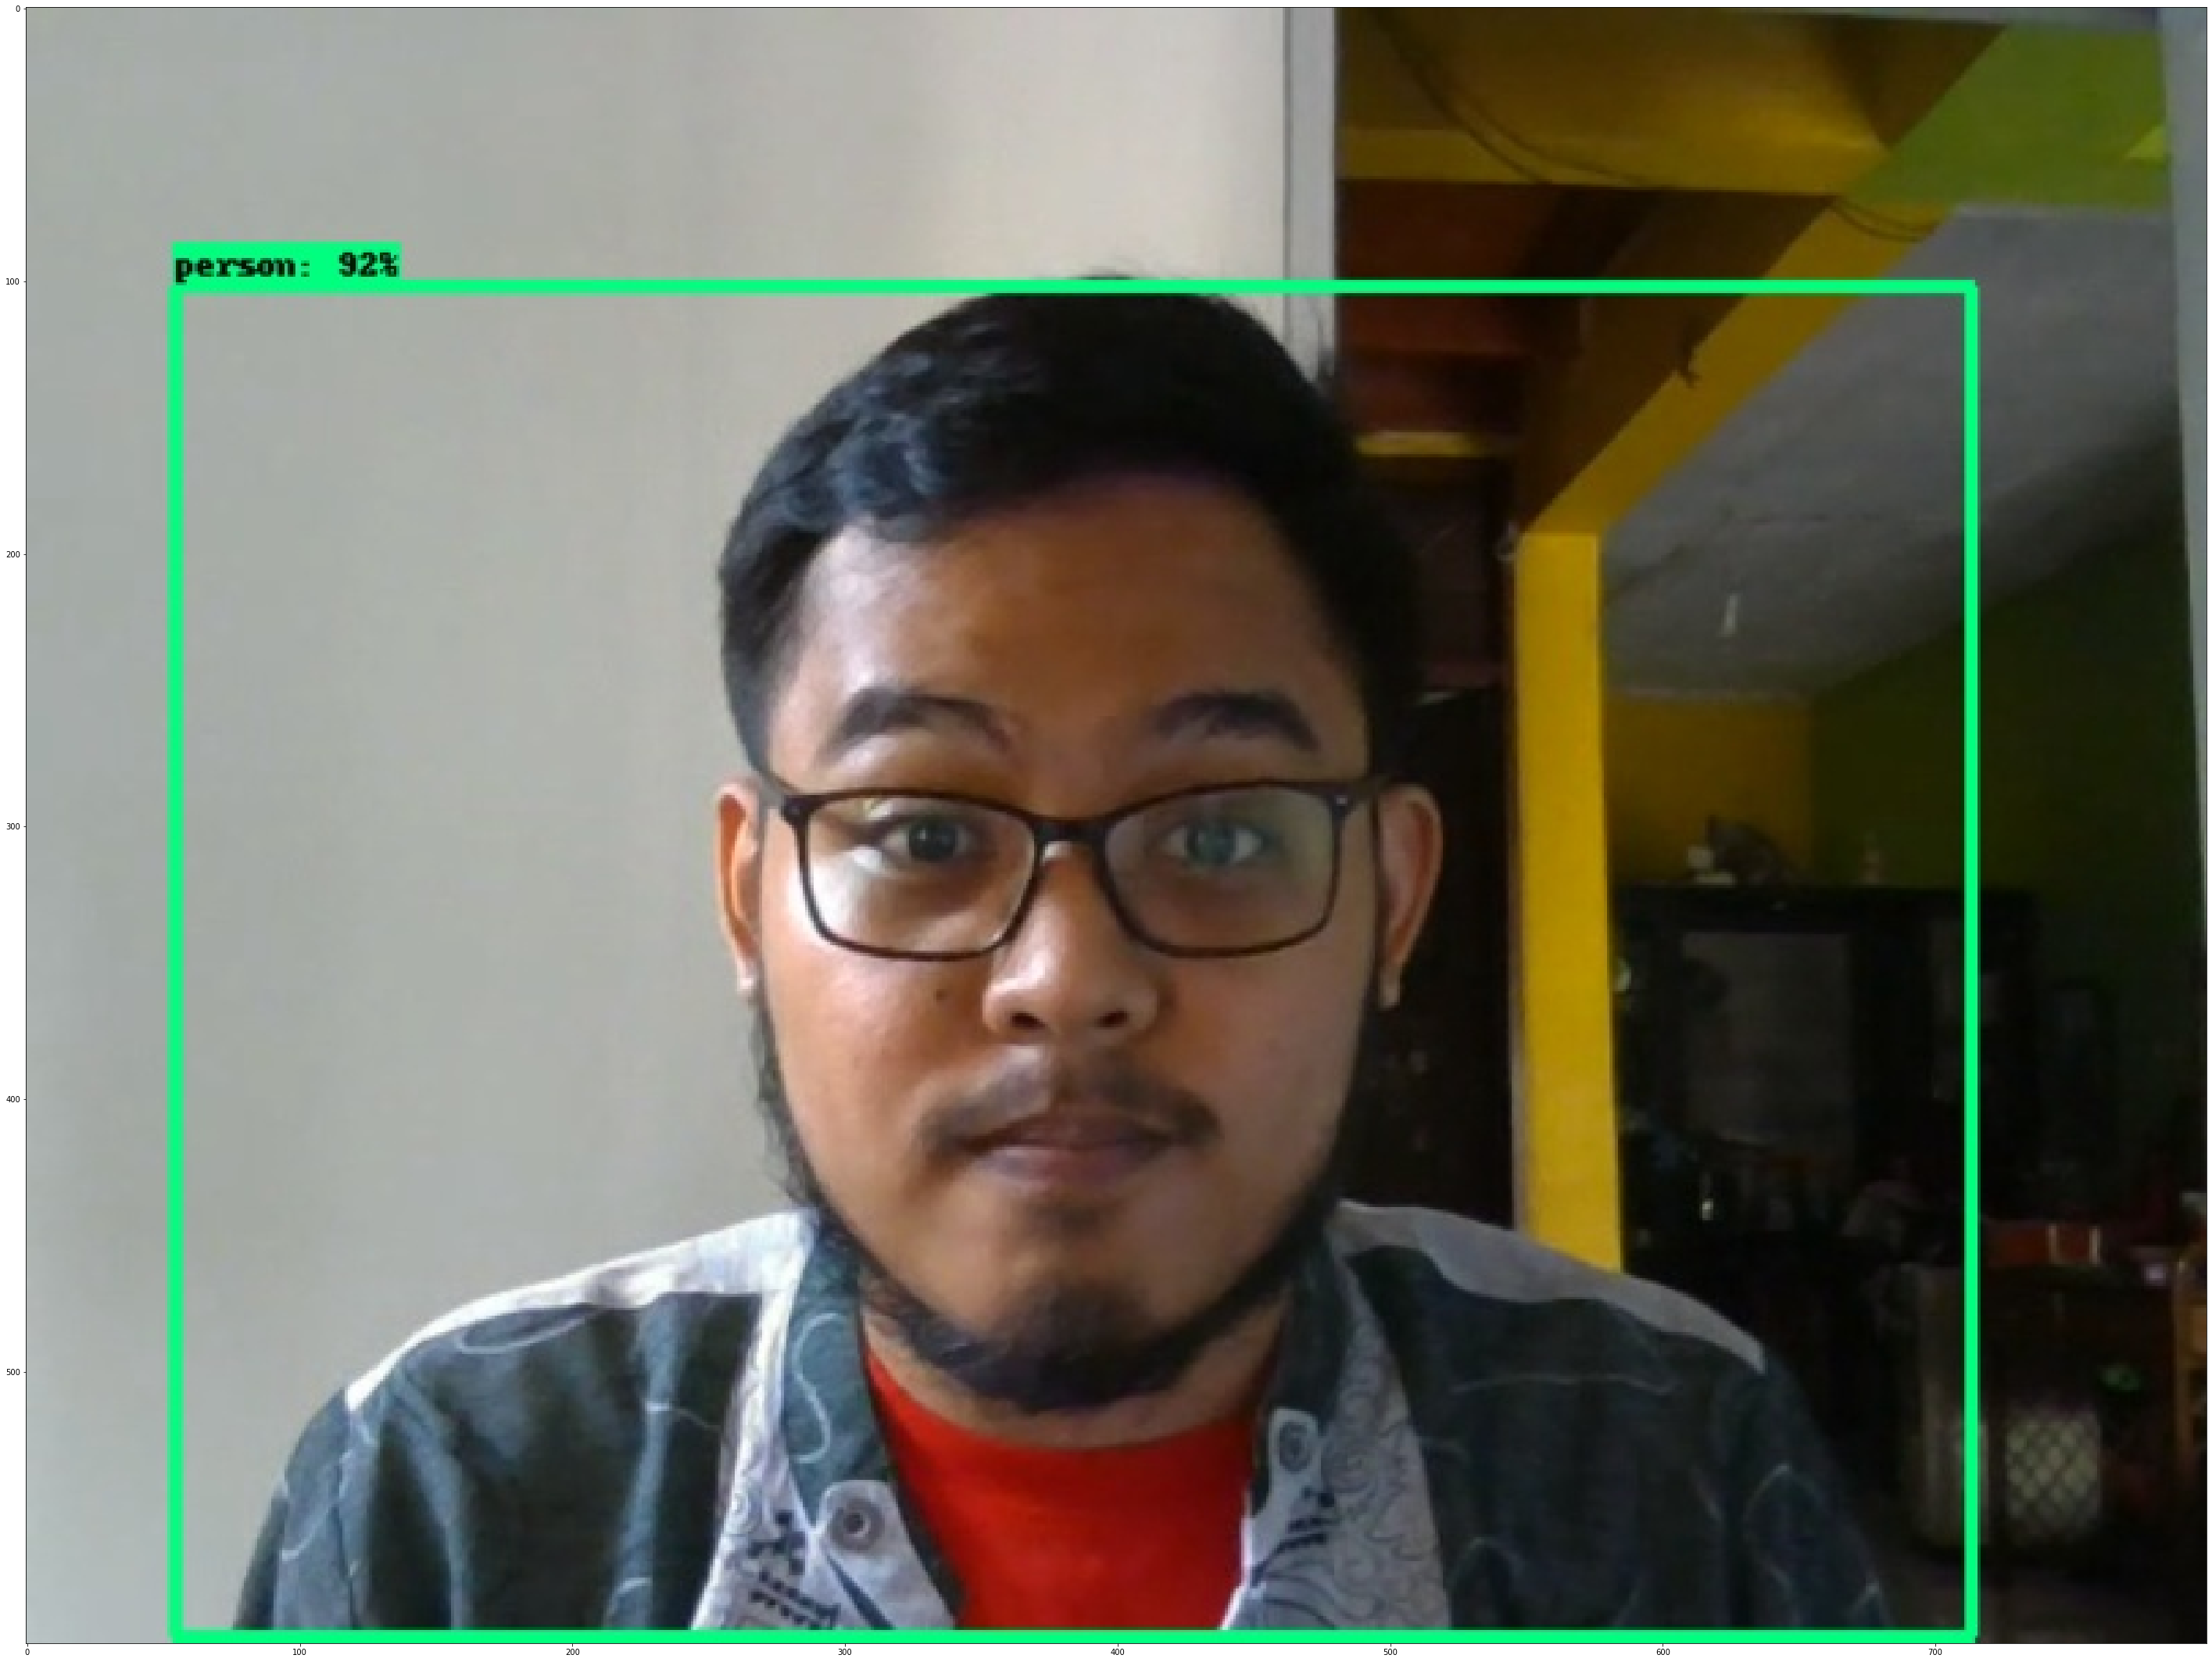

In [23]:
# Sample one result frame (sanity check)
sample_img = cv2.imread("data/frames/21.jpg")
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(50,50))
plt.imshow(sample_img)
plt.show()

#### Convert Frames into Result Video

In [24]:
# Load frames
frames = [cv2.imread("data/frames/%s.jpg" % i) for i in tqdm(range(n_frames-1))]
len(frames)

100%|██████████| 507/507 [00:16<00:00, 31.17it/s] 


507

In [25]:
# Write frames into video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data/videos/result_webcam.avi', fourcc, fps, (800,600))

for frame in tqdm(frames):
    out.write(frame)

100%|██████████| 507/507 [00:02<00:00, 201.73it/s]
